## **Simulation**

Importing required libraries

In [ ]:

import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as stats
import math
import numpy as np
import simpy
import simpy.events as evt
from scipy.optimize import linprog
import random
from random import sample

This block produces the time required to achieve the target endpoint at the highest speed of the acceleration.

In [ ]:
def timeTo(a, maxV, d):
    # a       constant acceleration, m/s²
    # maxV    maximumum velocity, m/s
    # d       distance, km
    # return  time in seconds required to travel
    # 
    ta = maxV/a         # time to accelerate to maxV
    da = a*ta**2        # distance traveled during acceleration from 0 to maxV and back to 0
    if (d < da):        # train never reaches full speed?
        return np.sqrt(4.0*d/a)     # time needed to accelerate to half-way point then decelerate to destination
    else:
        return 2*ta + (d-da)/maxV 

This block generates a data frame dependent on the number of chosen blocks.

In [ ]:
def data(N):
    data = pd.DataFrame()
    for i in range(N): 
                data.at[i, 'Start_Point'] = 'S' + str(i+1)
                data.at[i, 'End_Point'] = 'S' + str(i+2)
    
    return data

Manipulates the generated data frame by calibrating and inserting new columns such as Size, Actual Travle Time, Dwell Time.

In [ ]:
def structure_data(k):
    
    dt = data(k - 1)
            
    
    #Distance is splitted according to the number of blocks
    total_distance = 145000
    distance_split = total_distance / (k - 1)
    
    dt['Distance'] = distance_split
    dt['Actual_Travel_Time'] = ''
    dt['Dwell Time'] = np.random.normal(3.35,0.9, size= k - 1)     
    return dt

This block manipulates the generated data frame by modifying the data form of two columns from string to integer and replacing the values of two sections with the corresponding station names.

In [ ]:
k = 8
dt = structure_data(k)
dt['Distance']=dt['Distance'].apply(lambda x: int(x))
dt['Dwell Time']=dt['Dwell Time'].apply(lambda x: int(x))
dt['Start_Point'] = dt['Start_Point'].replace(['S1'],'London Old Oak Common')
dt['End_Point'] = dt['End_Point'].replace(['S'+str(k)],'Birmingham Interchange')

Calculation of the quantities of Drive Time, which is the time needed to reach the destination at the maximum speed.

In [ ]:
dt['Drive Time'] = timeTo(0.76, 86.1, 145000)/(k-1)
#for i in range(len(dt)):
    #dist = dt.at[i, 'Distance']
   # dt.at[i, 'Drive Time']=int(timeTo(0.76, 86.1, dist))

Creating a new column by measuring Dwell Time and Drive Time

In [ ]:
dt['Actual_Travel_Time'] = dt['Dwell Time'] + dt['Drive Time']
dt['Serial_Number'] = dt.index
dt

,Start_Point,End_Point,Distance,Actual_Travel_Time,Dwell Time,Drive Time,Serial_Number
0,London Old Oak Common,S2,20714,258.768249,2,256.768249,0
1,S2,S3,20714,257.768249,1,256.768249,1
2,S3,S4,20714,260.768249,4,256.768249,2
3,S4,S5,20714,258.768249,2,256.768249,3
4,S5,S6,20714,259.768249,3,256.768249,4
5,S6,S7,20714,259.768249,3,256.768249,5
6,S7,Birmingham Interchange,20714,259.768249,3,256.768249,6


In [ ]:
new1 = []
for i in range(len(dt)):
    new1.append(random.uniform(k*0.07,k*0.10))

In [ ]:
dt["Actual_Travel_Time"] =  dt["Actual_Travel_Time"] + sample(new1,1)
dt

,Start_Point,End_Point,Distance,Actual_Travel_Time,Dwell Time,Drive Time,Serial_Number
0,London Old Oak Common,S2,20714,259.444854,2,256.768249,0
1,S2,S3,20714,258.444854,1,256.768249,1
2,S3,S4,20714,261.444854,4,256.768249,2
3,S4,S5,20714,259.444854,2,256.768249,3
4,S5,S6,20714,260.444854,3,256.768249,4
5,S6,S7,20714,260.444854,3,256.768249,5
6,S7,Birmingham Interchange,20714,260.444854,3,256.768249,6


Trying to decide the starting point, Destination, by evaluating the difference of the real travel time and the wait period

In [ ]:
class Train(object):
        def __init__(self, i, dt, maxP = 600):
            self.name = ' [Train '+f"{i:2d}"+']'
            self.dt = dt
            self.maxP = maxP
            self.p = 0
     
     
        def process(self):
            for number in self.dt['Serial_Number']:
                count = 0
                data = self.dt[self.dt['Serial_Number'] == number]
                Start_Point = data['Start_Point'].tolist()
                End_Point = data['End_Point'].tolist()
                Start_Point = Start_Point[0]
                End_Point = End_Point[0]
                #print(End_Location)
                for loc in data['Start_Point']:
                    data1=dt[dt['Start_Point'] == loc]
                    streamtime=data1.iloc[0].at['Actual_Travel_Time']
                    dwelltime=data1.iloc[0].at['Dwell Time']
                    if number == 0:
                        yield env.timeout(100)
                    #yield env.timeout(dwelltime)
                    #print(Start_Location)
                    print(f"{now():s} {self.name:s} dep from {Start_Point:s} for {End_Point:s}")
                    yield env.timeout(streamtime)
                    print(f"{now():s} {self.name:s} arr {End_Point:s}")

This block provides, start time, end time, time between two trains from the starting point, taking into account the delay in the 9 am train.

In [ ]:
def line1(start=6*3600, stop=22*3600, timing=420):
        yield env.timeout(start-env.now)
        for i in range(int((stop-start)/timing)):
            if i==35:
                yield env.timeout(1800)
            p = Train(i, dt)
            env.process(p.process())
            yield env.timeout(timing)
         
         
         
def daytime(p):
    p=int(p)
    return f"{p//3600:02d}:{(p%3600)//60:02d}:{p%60:02d}"
def now():
    return daytime(env.now)

This is giving, start time, end time, time between two trains from starting point without considering the delay in 9 am train

In [ ]:
def line(start=6*3600, stop=10*3600, timing=420):
        yield env.timeout(start-env.now)
        for i in range(int((stop-start)/timing)):
            #if i==35:
             #   yield env.timeout(1800)
            p = Train(i, dt)
            env.process(p.process())
            yield env.timeout(timing)
         
         
         
def daytime(p):
    p=int(p)
    return f"{p//3600:02d}:{(p%3600)//60:02d}:{p%60:02d}"
def now():
    return daytime(env.now)

This results in the simulation of 48 trains running through 8 blocks with optimum safe speed with no delay, the first train beginning at 06:01:40 a.m. and the last train running at 10:42:04 a.m.

In [ ]:
env = simpy.Environment()   
env.process(line())
env.run()

06:01:40  [Train  0] dep from London Old Oak Common for S2
06:05:59  [Train  0] arr S2
06:05:59  [Train  0] dep from S2 for S3
06:08:40  [Train  1] dep from London Old Oak Common for S2
06:10:17  [Train  0] arr S3
06:10:17  [Train  0] dep from S3 for S4
06:12:59  [Train  1] arr S2
06:12:59  [Train  1] dep from S2 for S3
06:14:39  [Train  0] arr S4
06:14:39  [Train  0] dep from S4 for S5
06:15:40  [Train  2] dep from London Old Oak Common for S2
06:17:17  [Train  1] arr S3
06:17:17  [Train  1] dep from S3 for S4
06:18:58  [Train  0] arr S5
06:18:58  [Train  0] dep from S5 for S6
06:19:59  [Train  2] arr S2
06:19:59  [Train  2] dep from S2 for S3
06:21:39  [Train  1] arr S4
06:21:39  [Train  1] dep from S4 for S5
06:22:40  [Train  3] dep from London Old Oak Common for S2
06:23:19  [Train  0] arr S6
06:23:19  [Train  0] dep from S6 for S7
06:24:17  [Train  2] arr S3
06:24:17  [Train  2] dep from S3 for S4
06:25:58  [Train  1] arr S5
06:25:58  [Train  1] dep from S5 for S6
06:26:59  [Train

This results in the simulation of 48 trains running within 8 blocks with a maximum safe speed having a delay limit at 9 a.m. train due to a tehnic glitch, the first train beginning at 06:01:40 a.m. and the last train arriving at 10:42:04 a.m.

In [ ]:
env = simpy.Environment()   
env.process(line1())
env.run()

06:01:40  [Train  0] dep from London Old Oak Common for S2
06:05:59  [Train  0] arr S2
06:05:59  [Train  0] dep from S2 for S3
06:08:40  [Train  1] dep from London Old Oak Common for S2
06:10:17  [Train  0] arr S3
06:10:17  [Train  0] dep from S3 for S4
06:12:59  [Train  1] arr S2
06:12:59  [Train  1] dep from S2 for S3
06:14:39  [Train  0] arr S4
06:14:39  [Train  0] dep from S4 for S5
06:15:40  [Train  2] dep from London Old Oak Common for S2
06:17:17  [Train  1] arr S3
06:17:17  [Train  1] dep from S3 for S4
06:18:58  [Train  0] arr S5
06:18:58  [Train  0] dep from S5 for S6
06:19:59  [Train  2] arr S2
06:19:59  [Train  2] dep from S2 for S3
06:21:39  [Train  1] arr S4
06:21:39  [Train  1] dep from S4 for S5
06:22:40  [Train  3] dep from London Old Oak Common for S2
06:23:19  [Train  0] arr S6
06:23:19  [Train  0] dep from S6 for S7
06:24:17  [Train  2] arr S3
06:24:17  [Train  2] dep from S3 for S4
06:25:58  [Train  1] arr S5
06:25:58  [Train  1] dep from S5 for S6
06:26:59  [Train

# Optimisation

Loading the Dataset

In [ ]:
df=pd.read_csv('/content/sample_data/optimization.csv')

In [ ]:
df

,Number_of_Trains,Number_of_Blocks,Train_Travel_Time,Average_Delay_Time
0,2,2,30.000000,429.459459
1,3,5,20.000000,233.800000
2,6,3,10.000000,1319.633803
3,9,4,6.666667,1543.476190


In [ ]:
simulation_data = df
pd.options.mode.chained_assignment = None
 
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
import numpy as np

pd.options.mode.chained_assignment = None
target = pd.DataFrame(simulation_data['Average_Delay_Time'])
predictor = pd.DataFrame(simulation_data[['Number_of_Blocks', 'Number_of_Trains']])
predictor = sm.add_constant(predictor)
 
model = sm.OLS(target, predictor).fit()
predictions = model.predict(predictor)
model.summary()

/usr/local/lib/python3.6/dist-packages/statsmodels/stats/stattools.py:71: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  "samples were given." % int(n), ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     Average_Delay_Time   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.915
Method:                 Least Squares   F-statistic:                     17.25
Date:                Fri, 28 Aug 2020   Prob (F-statistic):              0.168
Time:                        20:10:43   Log-Likelihood:                -23.848
No. Observations:                   4   AIC:                             53.70
Df Residuals:                       1   BIC:                             51.85
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              407.4540    325.436      1.252      0.429   -3727.599    4542.507
Number_of_Blocks  -160.7072     86.693     -1.854      0.315   -1262.246     940.832
Number_of_Trains   207.3227     35.392      5.858      0.108    -242.379     657.024
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   2.348
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.542
Skew:                           0.717   Prob(JB):                        0.763
Kurtosis:                       1.905   Cond. No.                         23.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
#linear regression to find objective function
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
import numpy as np
 
def f(x,y):
    return 449.0231 + (-156.6402)*x + 209.8093*y # x: No of blocks, y: Trains_PH

In [ ]:
#this monte carlo optimisation for minimising travel time
import random
random.seed(0)
 
def monte_carlo(n, xmin=4, xmax=11, ymin=6, ymax=10):
    x = [ random.randint(xmin, xmax) for i in range(n)]
    y = [ random.randint(ymin, ymax) for i in range(n)]
    xp = [ x[0] ]
    yp = [ y[0] ]
    fmin = f(xp[0], yp[0])
    
    for i in range(1, len(x)):
        fi = f(x[i], y[i])
 
        if fi < fmin:
            xp += [x[i]]
            yp += [y[i]]
            fmin = fi
 
        xs = np.linspace(xmin, xmax, 100)
        ys = np.linspace(ymin, ymax, 100)
        xx, yy = np.meshgrid(xs, ys)
        z=f(xx, yy)
        
        fig, ax = plt.subplots(1, 1)
        fig.set_figwidth(6)
        fig.set_figheight(5)
        cs = ax.contourf(xs, ys, z, 100)
        fig.colorbar(cs, ax=ax)
        
        plt.scatter(x, y, c='red', marker='.')
        plt.plot(xp, yp, c='red')
        
        return len(xp), xp[-1], yp[-1], f(xp[-1], yp[-1])

(1, 10, 10, 980.7140999999997)

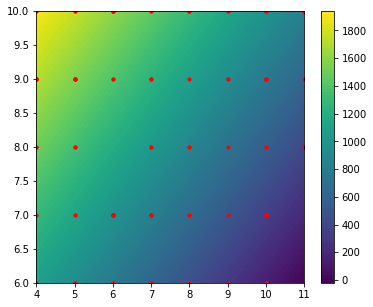

In [ ]:
random.seed(41)
monte_carlo(100)
# When Train per hour is 10
# Train interval is 6

(1, 11, 6, -15.163299999999936)

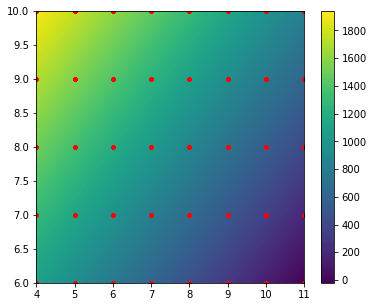

In [ ]:
random.seed(50)
monte_carlo(500)
# When Train per hour is 6
# Train interval is 10

(1, 11, 8, 404.4553000000001)

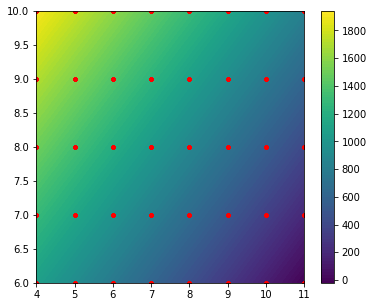

In [ ]:
random.seed(50)
monte_carlo(20000)
# When Train per hour is 8
# Train interval is 6

(1, 11, 7, 194.64600000000019)

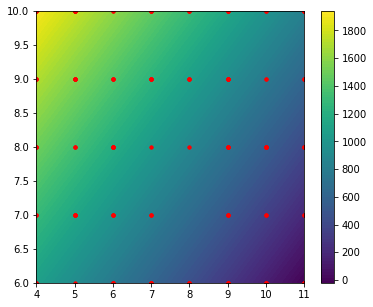

In [ ]:
random.seed(975898)
monte_carlo(250)
# When Train per hour is 8
# Train interval is 6